In [1]:
import numpy as np
import pandas as pd

import healpy as hp
from tqdm import tqdm, tqdm_notebook
import scipy as sp
from scipy.special import erf

import sys
from my_units import * 

from angular_fn import *
from template_fn import *
from cov_matrix_fn import *

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

HomeDir = './'
DataDir = HomeDir #+ 'code/'
### Set this to the directory where you store your data files (see below how to download them)
ListDir = HomeDir+'lists/hist_stats/'
FigDir = HomeDir+'figures/'

# Read in files

In [2]:
df_back = pd.read_csv(DataDir+'pairs_background_ruwe_w_st.csv', usecols = ['source_id', 'ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'pmra_pmdec_corr', 'pmra_eff_error', 'pmdec_eff_error', 'pmra_pmdec_eff_corr', 'parallax', 'parallax_error', 'pmra_sub', 'pmdec_sub', 'phot_g_mean_mag', 'ruwe'])
print('Backgrounds read in.')

df_fore = pd.read_csv(DataDir+'pairs_foreground_ruwe_w_st.csv', usecols = ['source_id', 'ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'ruwe'])
print('Foregrounds read in.')

In [ ]:
back_dist = pd.read_csv('bg_dist.csv', header=None)
fore_dist = pd.read_csv('fg_dist.csv', header=None)

In [ ]:
back_dist

,0,1,2,3
0,8246337986176,3971.99850,3198.10550,5133.20750
1,17390323414400,487.26510,477.90253,496.88528
2,44362718024064,2344.73300,1347.35780,3834.37600
3,45664092292480,394.70175,392.11835,397.17258
4,116479513433472,289.37510,280.17908,296.92358
...,...,...,...,...
61138838,6917516245821046528,2862.99660,1695.03850,5492.02640
61138839,6917519784871672064,2558.24500,1966.54490,3804.91460
61138840,6917521880819048704,6921.88800,4323.34200,11328.07700
61138841,6917526278863842944,4550.34470,3185.85900,6521.51100


# Quality cuts

In [ ]:
max_ruwe = 1.4

df_fore = df_fore[df_back['ruwe'] < max_ruwe]
back_dist = back_dist[df_back['ruwe'] < max_ruwe]
fore_dist = fore_dist[df_back['ruwe'] < max_ruwe]

df_back = df_back[df_back['ruwe'] < max_ruwe]


df_back = df_back[df_fore['ruwe'] < max_ruwe]
back_dist = back_dist[df_fore['ruwe'] < max_ruwe]
fore_dist = fore_dist[df_fore['ruwe'] < max_ruwe]

df_fore = df_fore[df_fore['ruwe'] < max_ruwe]


print(len(df_fore))

43387592


In [ ]:
back_dist_med = back_dist[1].to_numpy()
back_dist_lo = back_dist[2].to_numpy()
back_dist_hi = back_dist[3].to_numpy()

fore_dist_med = fore_dist[1].to_numpy()
fore_dist_lo = fore_dist[2].to_numpy()
fore_dist_hi = fore_dist[3].to_numpy()

nsigma = 2
condition = fore_dist_med + nsigma * (fore_dist_hi - fore_dist_med) < back_dist_med - nsigma * (back_dist_med - back_dist_lo)

df_fore = df_fore[condition]
df_back = df_back[condition]

fore_dist = fore_dist[condition]
back_dist = back_dist[condition]

back_dist_med = back_dist[1].to_numpy()
back_dist_lo = back_dist[2].to_numpy()
back_dist_hi = back_dist[3].to_numpy()

fore_dist_med = fore_dist[1].to_numpy()
fore_dist_lo = fore_dist[2].to_numpy()
fore_dist_hi = fore_dist[3].to_numpy()
print(len(df_fore))

10448136


In [ ]:
df_back['dist'] = back_dist_med
# take average of posterior widths
df_back['dist_error'] = ((back_dist_med - back_dist_lo) + (back_dist_hi - back_dist_med)) / 2

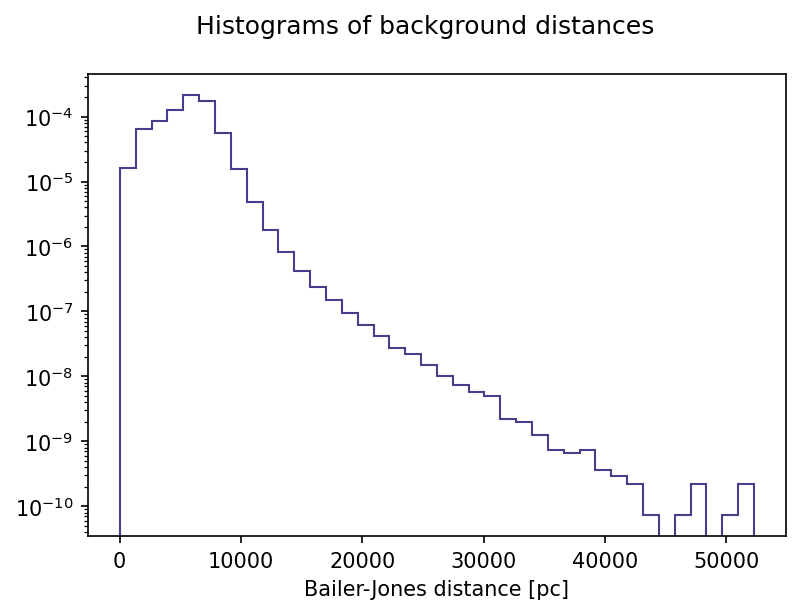

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
ax.hist(back_dist[1], log = True,  density = True, bins = 40, histtype='step', color = 'darkslateblue')
ax.set_xlabel(r'Bailer-Jones distance [pc]')
fig.suptitle('Histograms of background distances')
plt.show()

# Binning in location, distance, $G$-magnitude, and angular separation

## Import bin definitions

In [9]:
from bin_defs import *

hp.nside2npix(hp.order2nside(n)), len(bins_dist), len(bins_G), len(bins_bil)

(3072, 7, 14, 12)

In [10]:
(hp.nside2npix(hp.order2nside(n))-1) * (len(bins_dist)-1) * (len(bins_G)-1) * (len(bins_bil)-1)

2634918

## Bin assignments

In [11]:
### Get the pixel bin index for the background stars
q_pix = np.floor(df_back['source_id'].to_numpy() / fac_source_id).astype(int)
bins_pix = np.arange(np.min(np.unique(q_pix)), np.max(np.unique(q_pix))+2,1) # should be +2 to include sources in the last bin
q_binpix = np.digitize(q_pix, bins_pix)-1  # need to access the histogram matrix elements

# assign to G bins
bg_G = df_back['phot_g_mean_mag'].to_numpy()
q_bin_G = np.digitize(bg_G, bins_G) - 1  

# assign to radial bins
## necessary columns
fg_ra = df_fore['ra'].to_numpy()
fg_dec = df_fore['dec'].to_numpy()
bg_ra = df_back['ra'].to_numpy()
bg_dec = df_back['dec'].to_numpy()
## bil separation vectors
l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2

## bin definitions
q_bil = np.sqrt(l_bilnormsq)/arcsec
q_bin_bil = np.digitize(q_bil, bins_bil) - 1

In [12]:
# probabilistic assignment to distance bins
bg_dist = df_back['dist'].to_numpy()
# bg error is average of posteriors
bg_dist_error = df_back['dist_error'].to_numpy()

prob_dist = np.nan * np.ones((len(df_back),len(bins_dist)-1))
for i in tqdm(range(len(bins_dist)-1)):
    x1_list = (bins_dist[i]-bg_dist)/bg_dist_error/np.sqrt(2)
    x2_list = (bins_dist[i+1]-bg_dist)/bg_dist_error/np.sqrt(2)
    prob_dist[:,i] = 0.5*(erf(x2_list)-erf(x1_list))

100%|██████████| 6/6 [00:03<00:00,  1.60it/s]


In [13]:
prob_dist.shape

(10448136, 6)

## Function

In [14]:
def fn_pm_stats(df_fore, df_back, th_count=30, return_tab=False, n_sigma_out = 3): ### if return_tab=True returns the tab without pm outliers, else returns the data frame with stats 
    from scipy.special import erf

    # assign to healpix bins
    q_pix = np.floor(df_back['source_id'].to_numpy() / fac_source_id).astype(int)
    bins_pix = np.arange(np.min(np.unique(q_pix)), np.max(np.unique(q_pix))+2,1) # should be +2 to include sources in the last bin
    q_bin_pix = np.digitize(q_pix, bins_pix) - 1  # need to access the histogram matrix elements

    ### assign to G bins
    # assign to G bins
    bg_G = df_back['phot_g_mean_mag'].to_numpy()
    q_bin_G = np.digitize(bg_G, bins_G) - 1  

    # assign to radial bins
    ## necessary columns
    fg_ra = df_fore['ra'].to_numpy()
    fg_dec = df_fore['dec'].to_numpy()
    bg_ra = df_back['ra'].to_numpy()
    bg_dec = df_back['dec'].to_numpy()
    ## bil separation vectors
    l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
    l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2
    ## bin definitions
    q_bil = np.sqrt(l_bilnormsq)/arcsec
    q_bin_bil = np.digitize(q_bil, bins_bil) - 1   

    # probabilistic assignment to distance bins
    bg_dist = df_back['dist'].to_numpy()
    # bg error is average of posterior width in each direction
    bg_dist_error = df_back['dist_error'].to_numpy()
    
    prob_dist = np.nan * np.ones((len(df_back),len(bins_dist)-1))
    for i in range(len(bins_dist)-1):
        x1_list = (bins_dist[i]-bg_dist)/bg_dist_error/np.sqrt(2)
        x2_list = (bins_dist[i+1]-bg_dist)/bg_dist_error/np.sqrt(2)
        prob_dist[:,i] = 0.5*(erf(x2_list)-erf(x1_list))

    bg_pmra = df_back['pmra'].to_numpy(); bg_pmdec = df_back['pmdec'].to_numpy()
    ### histogram of summed probabilities
    hist_prob = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix], np.transpose(prob_dist), bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] 
    ### histogram of average pmra weighted by probabilities
    hist_pmra = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * bg_pmra, bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_pmra = hist_pmra / (hist_prob + 1e-20) #then divide by number in each bin
    hist_pmdec = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * bg_pmdec, bins=[bins_bil, bins_G, bins_pix], statistic='sum')[0] #sum first in each bin
    hist_pmdec = hist_pmdec / (hist_prob + 1e-20) #then divide by number in each bin
    
    ### For each star, get the mean pm of the corresponding bin
    mean_pmra = hist_pmra[:, q_bin_bil, q_bin_G, q_bin_pix].T; mean_pmdec = hist_pmdec[:, q_bin_bil, q_bin_G, q_bin_pix].T

    ### histogram of pm variance weighted by dist bin probabilities
    hist_pmra_var = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * (mean_pmra.T - bg_pmra)**2,
                                                    bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_pmra_var = hist_pmra_var / (hist_prob - 1 + 1e-20) # the estimator should have a -1 (this matches for example var() computed with panda's groupy)
    hist_pmdec_var = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * (mean_pmdec.T - bg_pmdec)**2,
                                                    bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_pmdec_var = hist_pmdec_var / (hist_prob - 1 + 1e-20) 
    hist_pmradec_var = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * (mean_pmra.T - bg_pmra) * (mean_pmdec.T - bg_pmdec),
                                                        bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_pmradec_var = hist_pmradec_var / (hist_prob - 1 + 1e-20) 
    
    ### set to nan bins where there are too few stars
    hist_pmra[hist_prob < th_count] = np.nan; hist_pmdec[hist_prob < th_count] = np.nan
    hist_pmra_var[hist_prob < th_count] = np.nan; hist_pmdec_var[hist_prob < th_count] = np.nan; hist_pmradec_var[hist_prob < th_count] = np.nan

    if return_tab==False: # returns the data frame with the statistics computed using tab
        ###  filler for generalized bins indices
        hist_bins_pix = np.ones(np.shape(hist_prob)) * bins_pix[:-1]
        hist_bins_G = np.transpose(np.transpose(np.ones(np.shape(hist_prob)),axes=[0,1,3,2]) * bins_G[:-1],axes=[0,1,3,2])
        hist_bins_bil = np.transpose(np.transpose(np.ones(np.shape(hist_prob)),axes=[0,3,2,1]) * bins_bil[:-1],axes=[0,3,2,1])
        hist_bins_dist = np.transpose(np.transpose(np.ones(np.shape(hist_prob)),axes=[3,1,2,0]) * bins_dist[:-1],axes=[3,1,2,0])

        ###  collect data and output
        data = np.transpose([hist_bins_pix, hist_bins_G, hist_bins_bil, hist_bins_dist, hist_prob, hist_pmra, hist_pmdec, hist_pmra_var, hist_pmdec_var, hist_pmradec_var],axes=[1,2,3,4,0])
        data = data.reshape(-1, data.shape[-1])
        return pd.DataFrame(data,columns=['pix','G_bin', 'bil_bin', 'dist_bin','number','mean_pmra','mean_pmdec','var_pmra','var_pmdec','var_pmradec'])
    
    else: # returns tab where the pm outliers more than n_sigma_out away from zero have been removed
        ### For each star, get the pm mean and variance of the corresponding bin (after excluding the low count bins)
        mean_pmra = hist_pmra[:, q_bin_bil, q_bin_G, q_bin_pix].T; mean_pmdec = hist_pmdec[:, q_bin_bil, q_bin_G, q_bin_pix].T
        var_pmra = hist_pmra_var[:, q_bin_bil, q_bin_G, q_bin_pix].T; var_pmdec = hist_pmdec_var[:, q_bin_bil, q_bin_G, q_bin_pix].T; var_pmradec = hist_pmradec_var[:, q_bin_bil, q_bin_G, q_bin_pix].T;    

        ###  Get the mean and var for each star
        tab_sum_pw = np.sum(prob_dist, axis=1, where=(~np.isnan(mean_pmra)))  # sum of the dist weights for each star using only bins with enough statistics 
        tab_mean_pmra = np.sum(np.nan_to_num(mean_pmra*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
        tab_mean_pmdec = np.sum(np.nan_to_num(mean_pmdec*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
        tab_var_pmra = np.sum(np.nan_to_num(var_pmra*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
        tab_var_pmdec = np.sum(np.nan_to_num(var_pmdec*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
        tab_var_pmradec = np.sum(np.nan_to_num(var_pmradec*prob_dist), axis=1)/(tab_sum_pw + 1e-20)        
        
        ### Replace the effective variance with the measurement errors for stars that have 0 mean (fall into empty bins)
        tab_var_pmra[tab_var_pmra==0] = (df_back['pmra_error'].to_numpy()[tab_var_pmra==0])**2
        tab_var_pmdec[tab_var_pmdec==0] = (df_back['pmdec_error'].to_numpy()[tab_var_pmdec==0])**2
        tab_var_pmradec[tab_var_pmradec==0] = (df_back['pmra_pmdec_corr'].to_numpy()*df_back['pmra_error'].to_numpy()*df_back['pmdec_error'].to_numpy())[tab_var_pmradec==0]
        
        ### subtracted pm and inverse covariance for outlier removal
        pm_sub = np.array([df_back['pmra'].to_numpy()-tab_mean_pmra, df_back['pmdec'].to_numpy()-tab_mean_pmdec]).T
        inv_cov_pm = np.linalg.inv(np.array([[tab_var_pmra, tab_var_pmradec], [tab_var_pmradec, tab_var_pmdec]]).T)
        mu_over_sigma_sq = inv_cov_pm[:, 0, 0]*pm_sub[:, 0]**2 + inv_cov_pm[:, 1, 1]*pm_sub[:, 1]**2 + 2*inv_cov_pm[:, 0, 1]*pm_sub[:, 0]*pm_sub[:, 1]
        
        return mu_over_sigma_sq

In [15]:
i=0
out_frac=1
n_iter = 10 # each iteration around 5 minutes
n_sigma_out = 3


while (i<n_iter) & (out_frac>1E-5):
    mu_sig_sq = fn_pm_stats(df_fore, df_back, th_count=30, return_tab=True, n_sigma_out = 3)
    i+=1; len_bg = len(df_back)
    df_back = df_back.iloc[mu_sig_sq < n_sigma_out**2]
    df_fore = df_fore.iloc[mu_sig_sq < n_sigma_out**2]
    out_frac=(1-len(df_back)/len_bg); 
    print('Iter '+str(i)+' -- fraction of outliers removed: '+str(out_frac*100)[:7]+' %')
    print('Number of stars remaining:' + str(len(df_back)))

df_back = df_back.iloc[mu_sig_sq < n_sigma_out**2]
df_fore = df_fore.iloc[mu_sig_sq < n_sigma_out**2]

Iter 1 -- fraction of outliers removed: 14.2507 %
Number of stars remaining:8959200
Iter 2 -- fraction of outliers removed: 1.87113 %
Number of stars remaining:8791561
Iter 3 -- fraction of outliers removed: 0.86473 %
Number of stars remaining:8715537
Iter 4 -- fraction of outliers removed: 0.38043 %
Number of stars remaining:8682380
Iter 5 -- fraction of outliers removed: 0.16397 %
Number of stars remaining:8668143
Iter 6 -- fraction of outliers removed: 0.07372 %
Number of stars remaining:8661752
Iter 7 -- fraction of outliers removed: 0.04002 %
Number of stars remaining:8658285
Iter 8 -- fraction of outliers removed: 0.01665 %
Number of stars remaining:8656843
Iter 9 -- fraction of outliers removed: 0.00865 %
Number of stars remaining:8656094
Iter 10 -- fraction of outliers removed: 0.00366 %
Number of stars remaining:8655777


In [16]:
np.save('bg_sub_ind.npy', df_back.index.values)

In [17]:
df_back

,source_id,ra,dec,pmra,pmdec,pmra_error,pmdec_error,pmra_pmdec_corr,parallax,parallax_error,phot_g_mean_mag,ruwe,pmra_sub,pmdec_sub,pmra_eff_error,pmdec_eff_error,pmra_pmdec_eff_corr,dist,dist_error
2,44362718024064,45.506006,0.495456,0.934795,0.320357,0.548966,0.559484,0.174756,-0.145891,0.517803,19.189219,1.194259,-2.704435,3.802161,5.638994,4.544521,-0.203361,2344.7330,1243.50910
53,1730322064500224,45.290283,2.881603,0.190329,0.388717,0.269778,0.247424,0.201122,-0.043157,0.287954,19.079718,0.958551,-2.508529,4.296689,4.606696,5.243475,-0.866790,2616.0002,1217.72025
64,2051555554134656,44.117295,3.558818,-0.086195,-0.061058,0.098963,0.090028,0.284681,0.054586,0.106445,17.599989,1.006210,-4.208723,6.673675,8.992337,7.682768,0.625186,4607.2393,1410.70205
76,2293993573501312,48.161769,2.885859,1.062064,0.288378,0.444607,0.374799,0.133582,0.013780,0.370777,19.562391,1.046555,-2.770720,4.698800,4.079017,4.780795,-0.415122,2452.2930,753.14785
260,7952905042726912,43.220563,6.349262,-0.258325,-0.695214,0.317765,0.263508,0.156281,-0.130584,0.263905,19.073437,0.992224,-5.155241,4.736531,8.265163,3.868450,-0.682328,3014.5645,1030.42640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61137798,6914657313723434112,310.531135,-4.217265,-0.040953,-0.176929,0.198044,0.166616,0.322804,-0.108888,0.168587,18.520987,1.034639,1.386192,4.201559,3.332869,2.577593,0.244396,5150.7960,1639.59015
61138009,6915035545723990016,311.761958,-3.769728,-0.054981,-0.335421,0.196297,0.169586,0.377381,0.582755,0.180099,18.513332,1.019746,0.626125,4.694711,5.083669,4.925378,0.217053,1858.4957,600.70540
61138151,6915443327097818112,315.470345,-3.820810,-0.010056,-0.696565,0.348701,0.281561,0.040716,0.379981,0.323976,19.397343,1.020808,1.077903,4.700766,4.858146,4.030911,0.409669,2972.4620,1213.74560
61138437,6916390968683209472,316.178217,-1.469753,1.019994,-0.154919,0.445302,0.489206,0.518798,0.887975,0.421485,19.690268,1.057806,1.638456,5.527198,6.644035,5.201203,0.196852,1209.5330,545.10935


In [18]:
df_pm_stats = fn_pm_stats(df_fore, df_back, return_tab=False)  
df_pm_stats.to_csv('bg_pm_hist.csv') #write to file

In [29]:
np.max(mu_sig_sq)

6941.360075794276

(array([8.656093e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([3.75361473e-07, 1.38827202e+02, 2.77654403e+02, 4.16481605e+02,
        5.55308806e+02, 6.94136008e+02, 8.32963209e+02, 9.71790411e+02,
        1.11061761e+03, 1.24944481e+03, 1.38827202

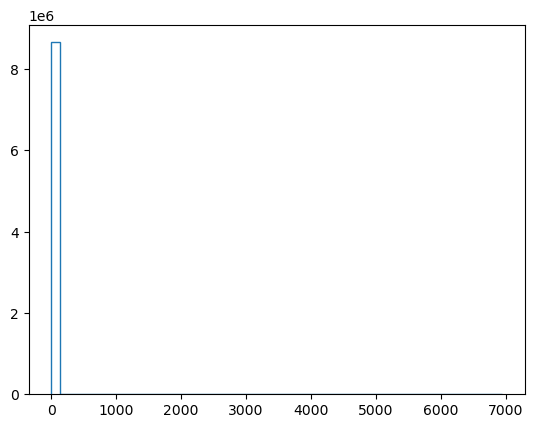

In [28]:
plt.hist(mu_sig_sq, bins = 50, histtype='step')

In [19]:
df_pm_stats.shape

(2635776, 10)

In [20]:
df_pm_stats

,pix,G_bin,bil_bin,dist_bin,number,mean_pmra,mean_pmdec,var_pmra,var_pmdec,var_pmradec
0,0.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,3.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,4.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2635771,3067.0,22.0,3.0,10000.0,0.0,NaN,NaN,NaN,NaN,NaN
2635772,3068.0,22.0,3.0,10000.0,0.0,NaN,NaN,NaN,NaN,NaN
2635773,3069.0,22.0,3.0,10000.0,0.0,NaN,NaN,NaN,NaN,NaN
2635774,3070.0,22.0,3.0,10000.0,0.0,NaN,NaN,NaN,NaN,NaN


In [21]:
a = df_pm_stats['number'].to_numpy()

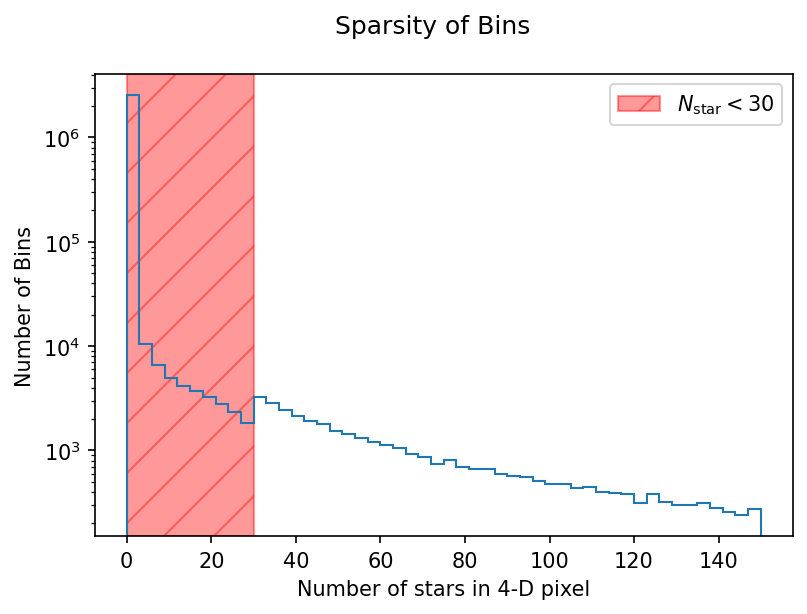

In [22]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)

plt.hist(a[a<150], bins = 50, log = True, histtype='step')
ax.set_xlabel(r'Number of stars in 4-D pixel')
ax.set_ylabel(r'Number of Bins')
#plt.axvline(x=30, color='r', linestyle='--', label = r'$N_{\mathrm{min}} = 30$')
ax.axvspan(0, 30 , alpha=0.4, color='red', label = r'$N_{\mathrm{star}} < 30$', hatch = '/')

plt.legend()
fig.suptitle(r'Sparsity of Bins')

plt.show()